In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

![title](data/download-google-play-store.png)


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)}) #may remove it later

#may remove it later
# import plotly
# # connected=True means it will download the latest version of plotly javascript library.
# plotly.offline.init_notebook_mode(connected=True)
# import plotly.graph_objs as go

# import plotly.figure_factory as ff
# import cufflinks as cf
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(14)

df = pd.read_csv('../android-app-market-analysis/data/googleplaystore.csv')

df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9382,ZOMBIE RIPPER,GAME,3.7,16073,94M,"500,000+",Free,0,Mature 17+,Action,"November 14, 2017",1.4,4.0 and up
2737,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device
7351,tutti.ch - Free Classifieds,SHOPPING,4.4,9950,15M,"500,000+",Free,0,Everyone,Shopping,"July 18, 2018",3.7.1,4.1 and up
8634,File Viewer for Android,TOOLS,4.1,7063,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"January 25, 2018",2.3.2,5.0 and up
4383,Hands 'n Guns Simulator,FAMILY,3.9,19727,76M,"1,000,000+",Free,0,Teen,Simulation,"July 3, 2018",32,4.1 and up


In [5]:
print('Number of apps in the dataset : ' , len(df), '\n')
df.drop_duplicates(subset='App', inplace=True)
print('Number of apps in the dataset after removing duplicates: ' , len(df),'\n')

# get the number of missing data points per column
print("Numer of missing values per column:")
missing_values_count = df.isnull().sum()
print(missing_values_count)

Number of apps in the dataset :  10841 

Number of apps in the dataset after removing duplicates:  9660 

Numer of missing values per column:
App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


In [6]:
# How many total missing values do we have?
total_cells = df.size
total_missing = missing_values_count.sum()

# percent of data that is missing
percentage_missign_values = (total_missing/total_cells) * 100
print(percentage_missign_values, '%')

1.175346392737697 %


In [7]:
for column in df.columns:
    print(df[column].value_counts())

BI Mobile Banking                                    1
Pocket Heroes                                        1
CS-Touch                                             1
Picai - Smart AI Camera                              1
APUS Booster - Space Cleaner & Booster               1
RETRO Shocked DW-6000                                1
M3-X5-X6-M-İ3-İ8 RACİNG 2018                         1
What is my IP address                                1
Font Studio- Photo Texts Image                       1
12 Step Meditations & Sober Prayers AA NA AL-ANON    1
Invoice & Time Tracking - Zoho                       1
Relax Rain ~ Rain Sounds                             1
                                                    ..
chat dz                                              1
Talking Angela                                       1
BS Play                                              1
Dinosaur War                                         1
BakaReader EX                                        1
Podcast Ap

In [8]:
# Column: Installs -> Remove Wrong Values ('Free'), remove + and , then typecast it to float
                
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: float(x))
print(type(df['Installs'][0]))

<class 'numpy.float64'>


In [9]:
# Column: Size -> Remove 'M', Replace 'k' and divide by 1000 (1MB = 1000 KB)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN'))

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', ''))
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', ''))
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

# Column: Price -> Remove '$' sign
df['Price'] = df['Price'].apply(lambda x: float(str(x).replace('$', '')))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

# Column: Last_Updated 
df["Last Updated"] = pd.to_datetime(df['Last Updated'])

print(df.dtypes)

App                       object
Category                  object
Rating                   float64
Reviews                    int64
Size                     float64
Installs                 float64
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
dtype: object


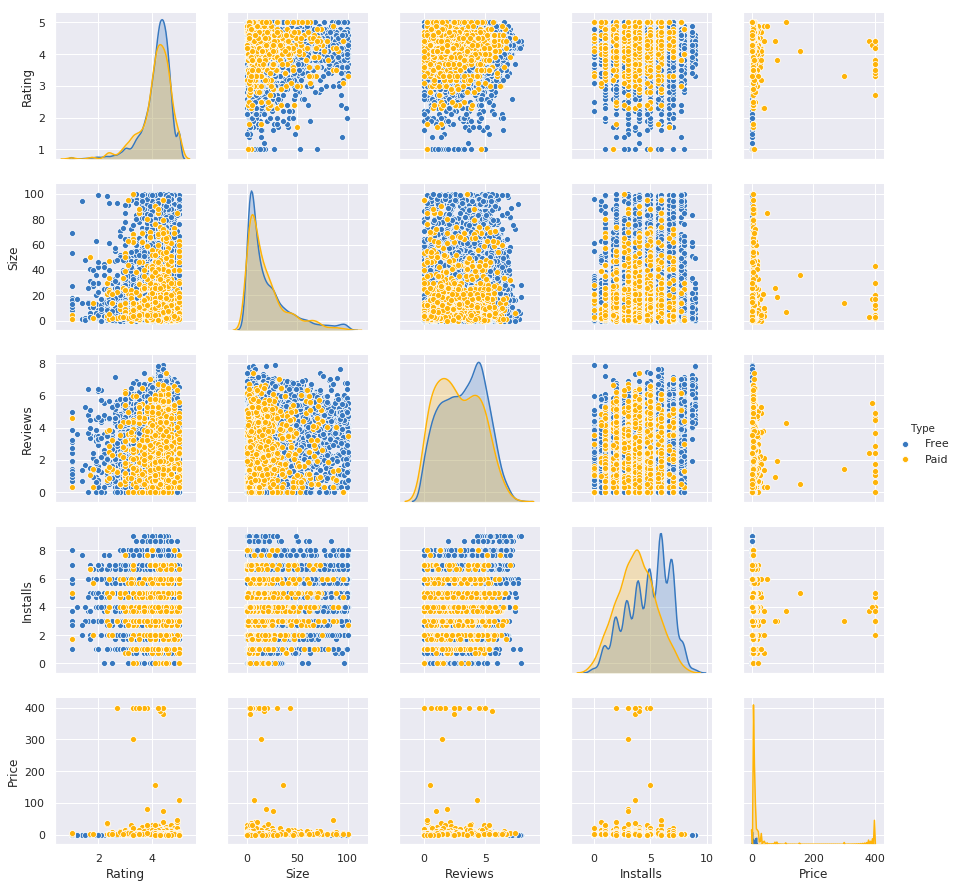

In [10]:
rating = df['Rating'].dropna()
size = df['Size'].dropna()
installs = np.log10(df['Installs'][df.Installs!=0].dropna()) #eliminate zeros for computing log
reviews = np.log10(df['Reviews'][df.Reviews!=0].dropna()) #eliminate zeros for computing log
app_type = df['Type'].dropna()
price = df['Price']

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
p = sns.pairplot(pd.DataFrame(list(zip(rating, size, reviews, installs, app_type, price)), 
                        columns=['Rating','Size', 'Reviews', 'Installs', 'Type', 'Price']), hue='Type', palette=sns.xkcd_palette(colors))

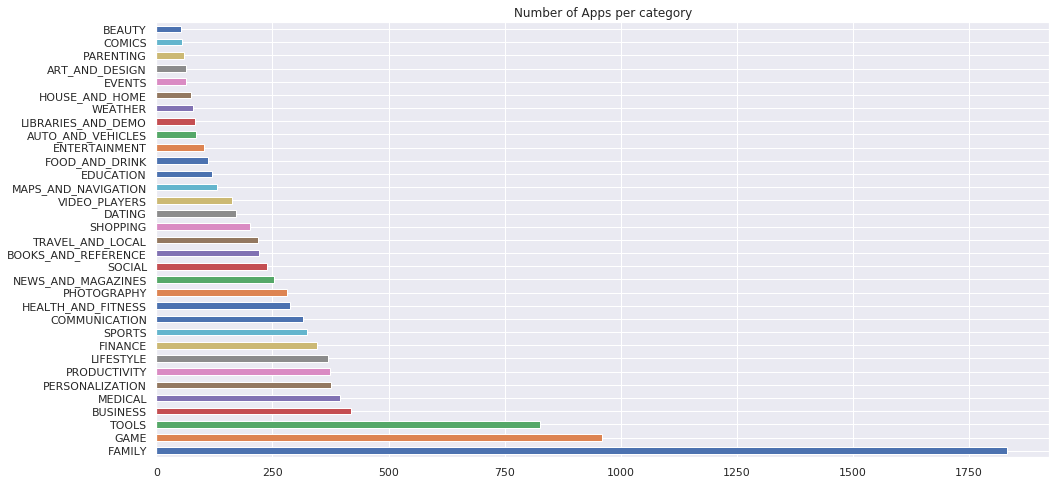

In [11]:
df['Category'].value_counts().plot(kind='barh',figsize= (16,8))
title=plt.title('Number of Apps per category')

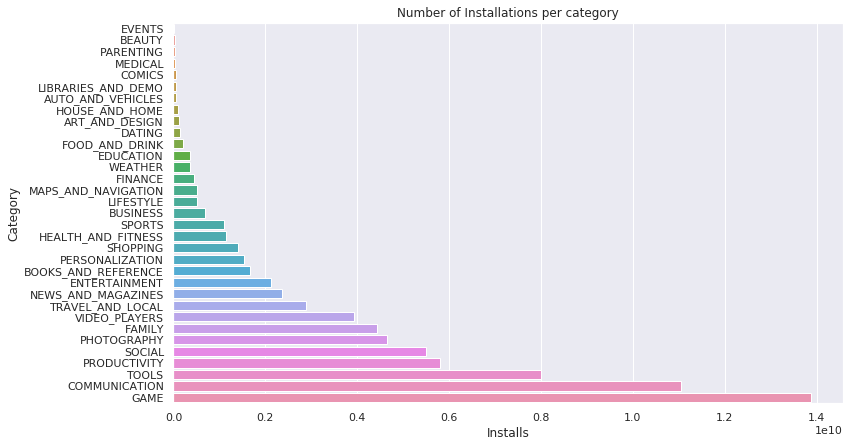

In [12]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Number of Installations per category')
result = df.groupby(["Category"])['Installs'].aggregate(np.sum).reset_index().sort_values('Installs')
bar=sns.barplot(y='Category',x='Installs', data=result, ci=None, order=result['Category'])
plt.show(bar)

Average app rating =  4.173243045387998


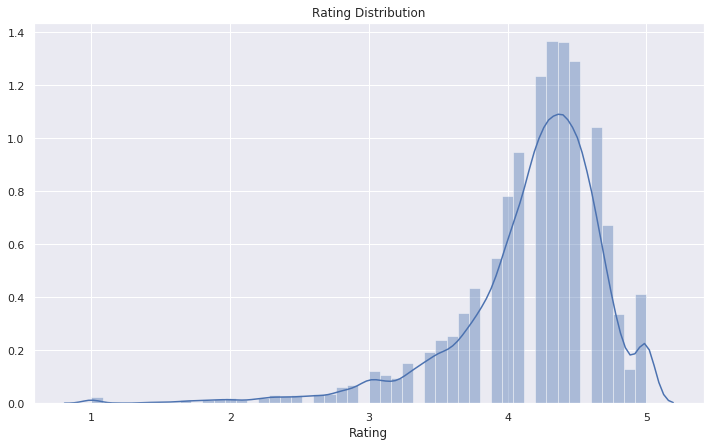

In [13]:
ig = plt.figure(figsize=(12,7))
title=plt.title('Rating Distribution')
hist=sns.distplot(df.Rating.dropna(),kde=True)
print('Average app rating = ', np.mean(df.Rating))
plt.show(hist)

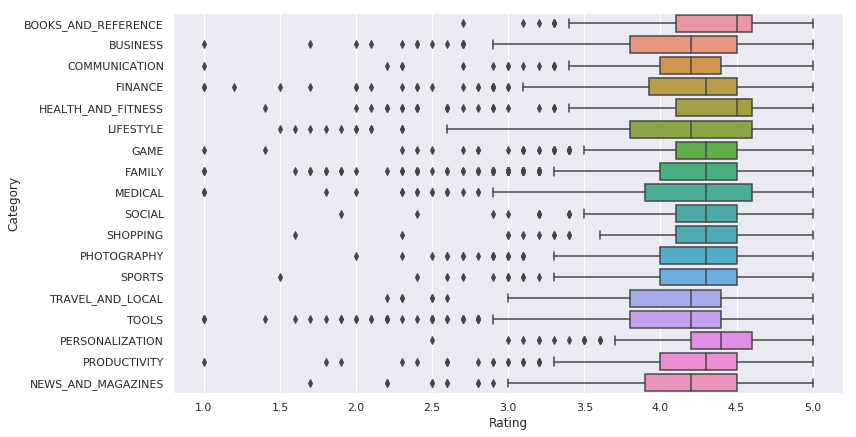

In [14]:
fig = plt.figure(figsize=(12,7))
cat_rate = df.groupby("Category").filter(lambda x: len(x) > 200)
bar = sns.boxplot(x="Rating", y="Category", data=cat_rate)
plt.show(bar)

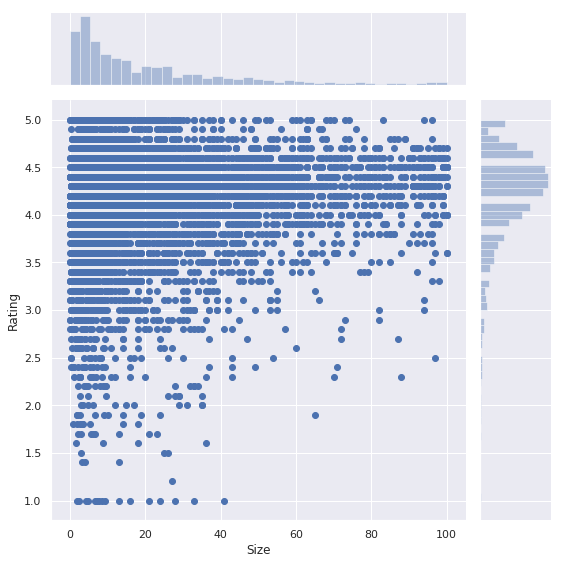

In [15]:
plot = sns.jointplot(df.Size, df.Rating,size=8)

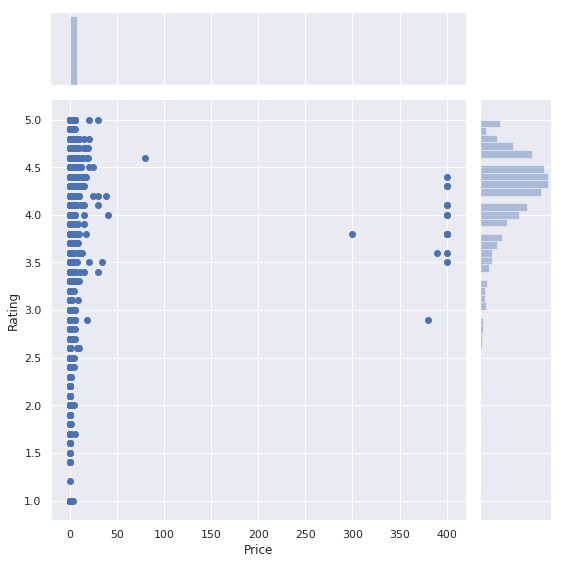

In [16]:
plot = sns.jointplot(df.Price, df.Rating,size=8)

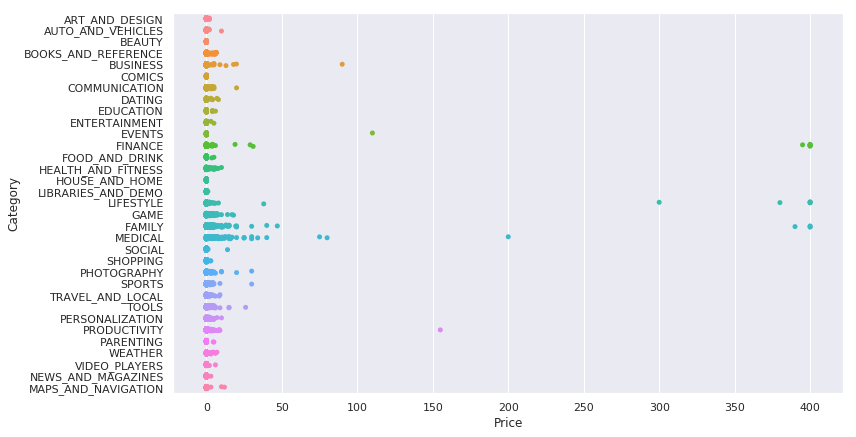

In [17]:
fig = plt.figure(figsize=(12,7))
result = df.groupby(["Category"])['Price'].aggregate(np.mean).reset_index().sort_values('Price')
# bar=sns.barplot(y='Category',x='Price', data=result, ci=None, order=result['Category'])
bar=sns.stripplot(y='Category',x='Price', data=df)
plt.show(bar)

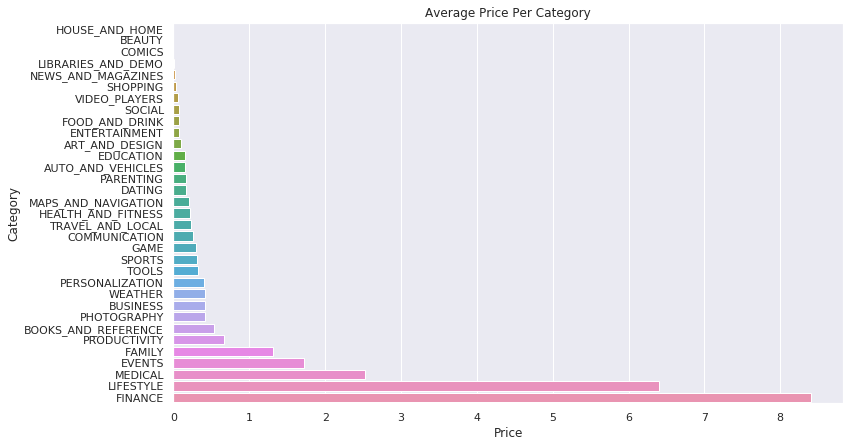

In [18]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Price Per Category')
result = df.groupby(["Category"])['Price'].aggregate(np.mean).reset_index().sort_values('Price')
bar=sns.barplot(y='Category',x='Price', data=result, ci=None, order=result['Category'])
plt.show(bar)

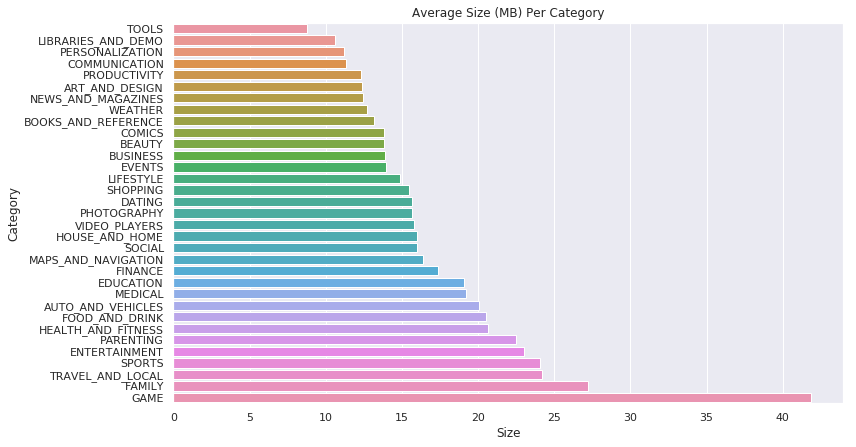

In [19]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Size (MB) Per Category')
result = df.groupby(["Category"])['Size'].aggregate(np.mean).reset_index().sort_values('Size')
bar=sns.barplot(y='Category',x='Size', data=result, ci=None, order=result['Category'])
plt.show(bar)

In [20]:
df[['Category', 'App','Price']][df.Price > 200]

,Category,App,Price
4197,FAMILY,most expensive app (H),399.99
4362,LIFESTYLE,💎 I'm rich,399.99
4367,LIFESTYLE,I'm Rich - Trump Edition,400.00
5351,LIFESTYLE,I am rich,399.99
5354,FAMILY,I am Rich Plus,399.99
5355,LIFESTYLE,I am rich VIP,299.99
5356,FINANCE,I Am Rich Premium,399.99
5357,LIFESTYLE,I am extremely Rich,379.99
5358,FINANCE,I am Rich!,399.99
5359,FINANCE,I am rich(premium),399.99


In [21]:
df = df[df.Price < 100]

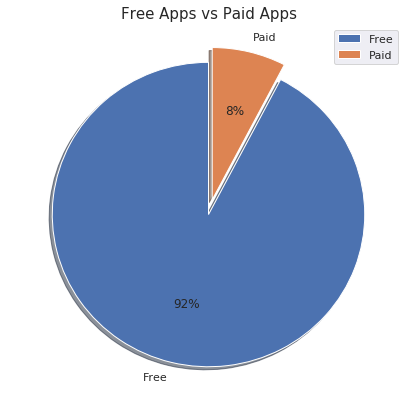

In [22]:
fig = plt.figure(figsize = (7,7))
labels = ['Free', 'Paid'] 
size = df['Type'].value_counts()
explode = [0, 0.1]

plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, autopct='%1.0f%%')
plt.title('Free Apps vs Paid Apps', fontsize = 15)
plt.legend()
plt.show()

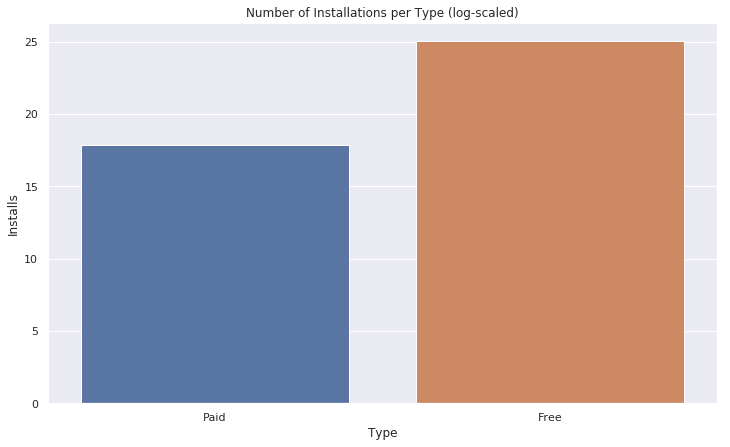

In [23]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Number of Installations per Type (log-scaled)')
result = df.groupby(["Type"])['Installs'].aggregate(np.sum).reset_index().sort_values('Installs')
bar=sns.barplot(x='Type',y=np.log(result.Installs), data=result, ci=None, order=result['Type'])
plt.show(bar)

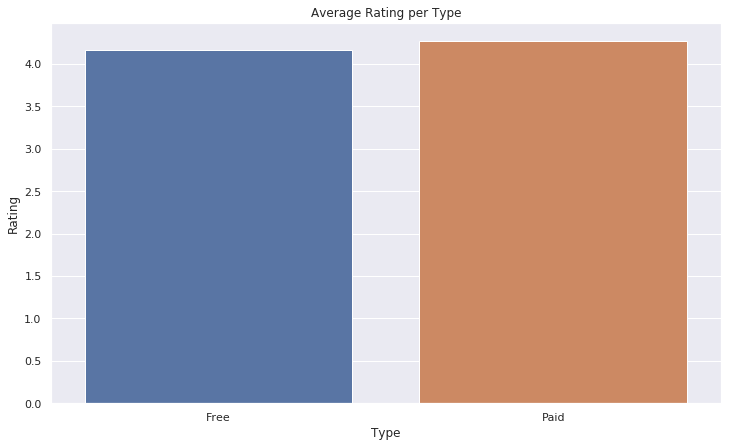

In [24]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Rating per Type')
result = df.groupby(["Type"])['Rating'].aggregate(np.mean).reset_index().sort_values('Rating')
bar=sns.barplot(x='Type',y=result.Rating, data=result, ci=None, order=result['Type'])
plt.show(bar)

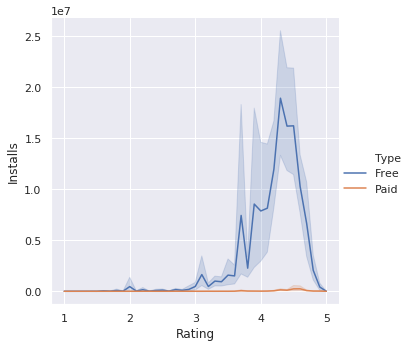

In [25]:
sns.relplot(x="Rating", y="Installs", hue = 'Type' , kind = 'line' , data=df)

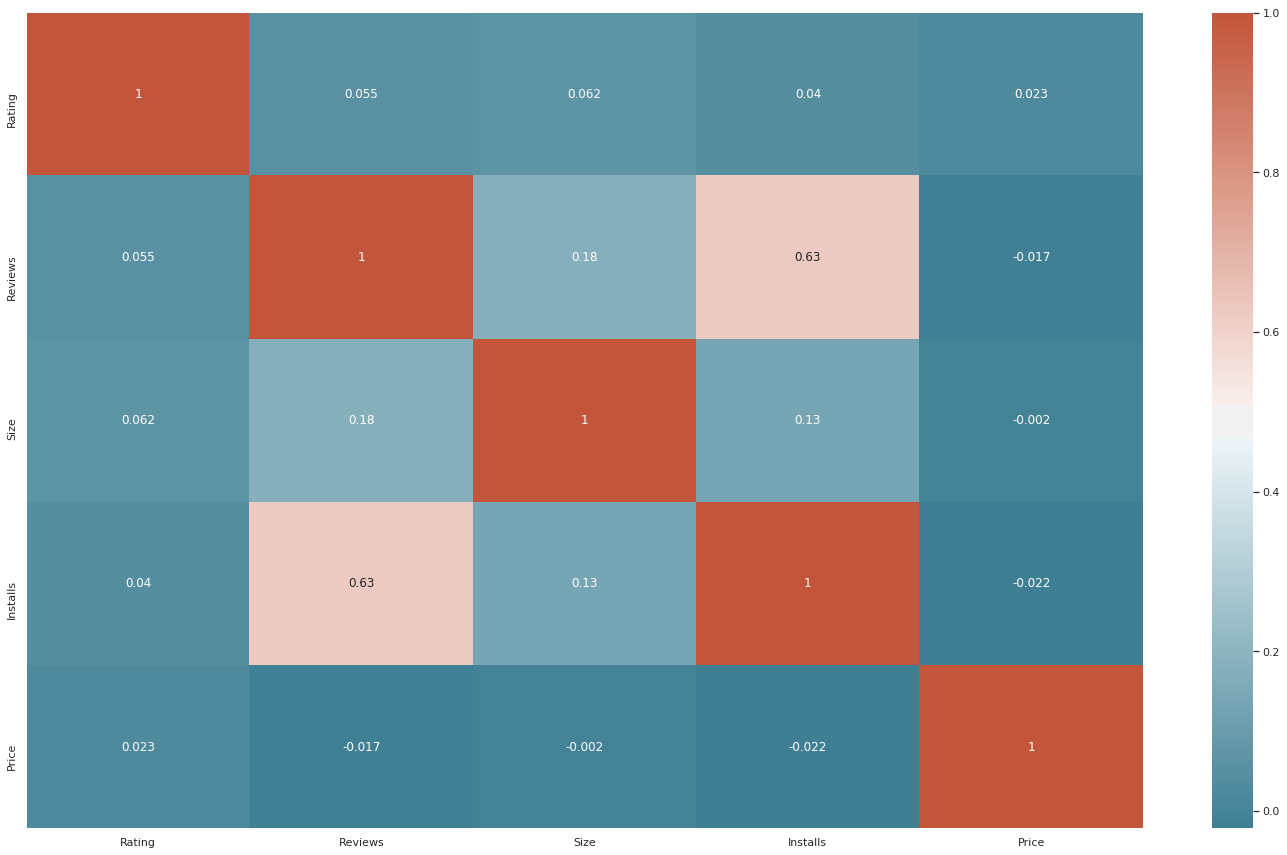

In [26]:
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [27]:
reviews_df = pd.read_csv('../android-app-market-analysis/data/googleplaystore_user_reviews.csv')
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

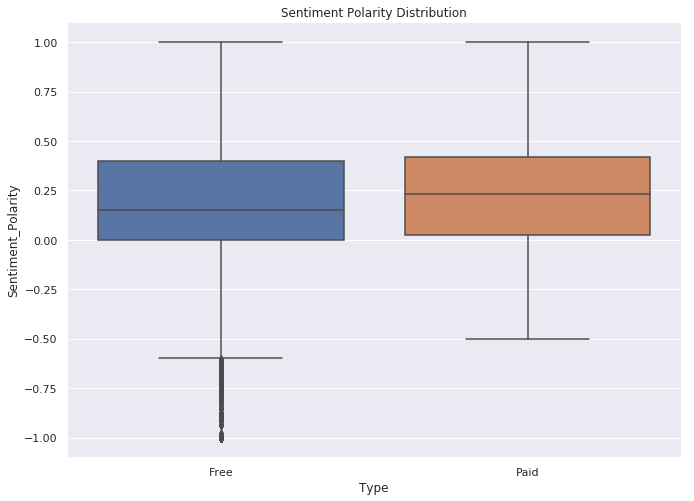

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Sentiment Polarity Distribution')

In [29]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=500, colormap="Set2")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

merged_df['Translated_Review'] = merged_df['Translated_Review'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
merged_df.Translated_Review = merged_df.Translated_Review.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
merged_df.dropna(subset=['Translated_Review'], inplace=True)

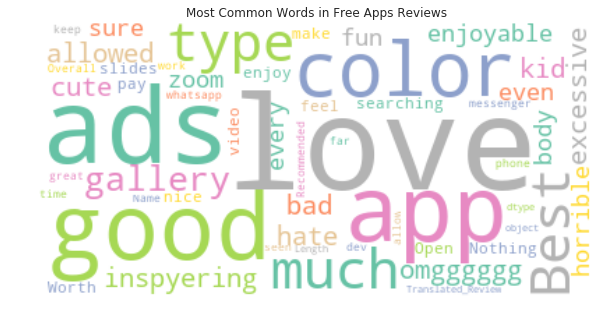

In [30]:
free = merged_df.loc[merged_df.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 15))
plt.title('Most Common Words in Free Apps Reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

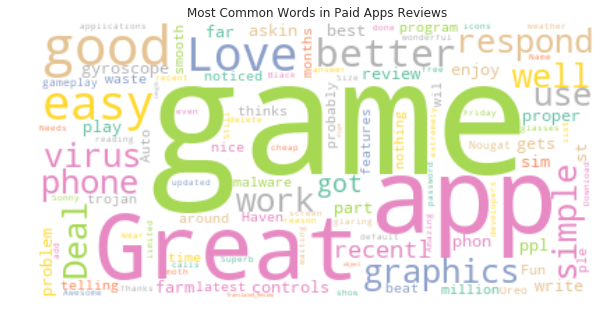

In [31]:
paid = merged_df.loc[merged_df.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(paid)))
plt.figure(figsize=(10, 15))
plt.title('Most Common Words in Paid Apps Reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()